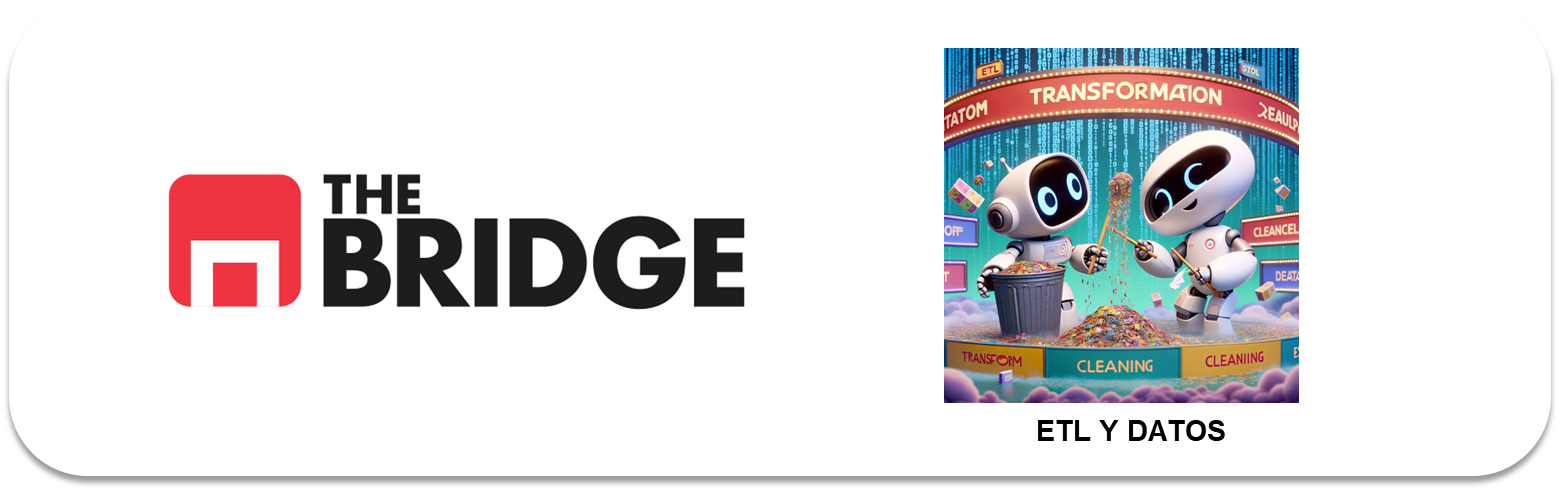

## PRACTICA OBLIGATORIA: Transformación y limpieza

* La práctica obligatoria de esta unidad consiste en cargar un dataset de Netflix y hacer un repaso completo del mismo, limpiando, transformando y creando algunas variables. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

## #0 Carga de datos y primera exploración

In [1]:
import numpy as np
import pandas as pd

df_peliculas = pd.read_csv("data/dataset_netflix_titles.csv")


In [3]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Haz una primera exploración de los datos. Haz una primera visualización de la tabla, muestra la información general, la descripción de las variables numéricas, las columnas y muestra la distribución de datos de tres columnas escogidas por ti.

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

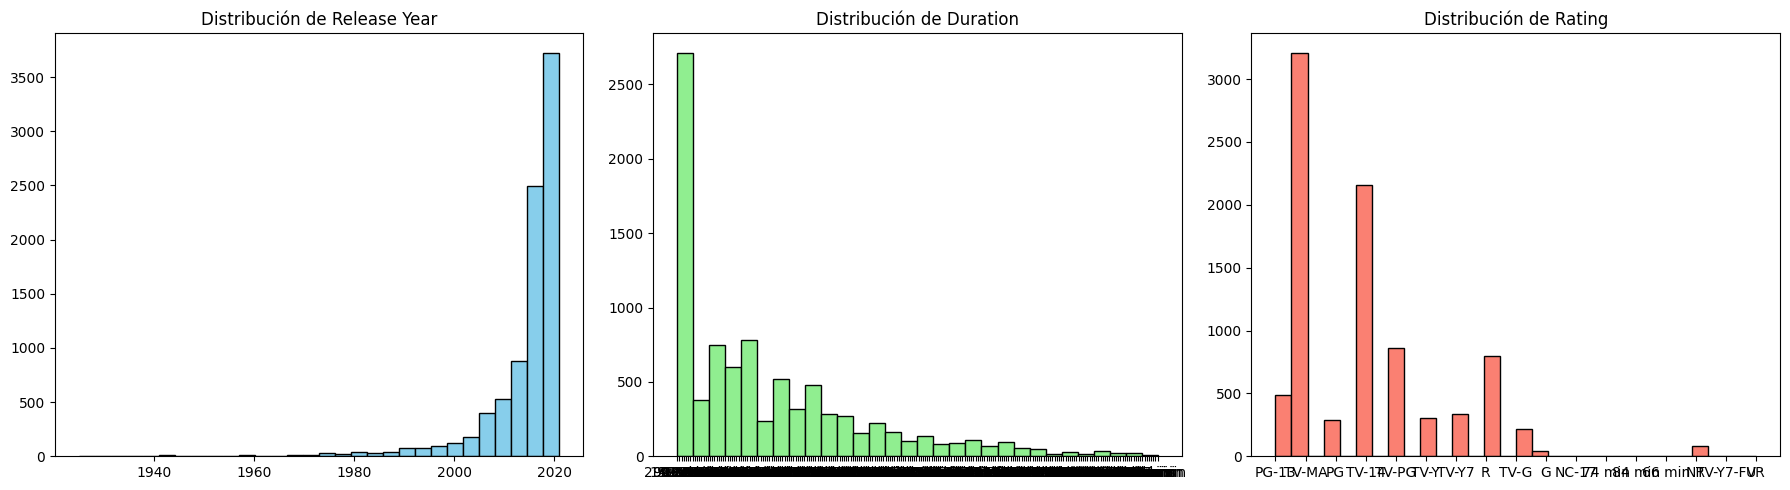

In [4]:
import matplotlib.pyplot as plt

# 1. Mostrar las primeras filas del DataFrame
print(df_peliculas.head())

# 2. Información general del DataFrame
print(df_peliculas.info())

# 3. Descripción de las variables numéricas
print(df_peliculas.describe())

# 4. Distribución de datos de tres columnas
# Seleccionamos 3 columnas que nos interesen, por ejemplo: 'release_year', 'duration', 'rating'
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de 'release_year'
axes[0].hist(df_peliculas['release_year'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Release Year')

# Histograma de 'duration'
axes[1].hist(df_peliculas['duration'].dropna(), bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribución de Duration')

# Histograma de 'rating'
axes[2].hist(df_peliculas['rating'].dropna(), bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Distribución de Rating')

plt.tight_layout()
plt.show()


## #1 Duplicados y cardinalidad

1. ¿Existen filas duplicadas?¿Cuántas?

In [5]:
# Comprobar filas duplicadas en el DataFrame
duplicados = df_peliculas.duplicated().sum()
print(f'Número de filas duplicadas: {duplicados}')


Número de filas duplicadas: 0


2. Deshazte de las filas duplicadas, si las hubiera. Quédate con las últimas copias.

3. Ahora que no hay duplicados, tiene sentido calcular la cardinalidad de cada columna. Haz un programa que la obtenga y guarde el resultado en un diccionario con claves el nombre de las columnas y valores la cardinalidad (tal y como la hemos visto en el workout) de cada columna. [Nota: ¿has tenido en cuenta los valores nulos?]

In [6]:
# Calcular la cardinalidad de cada columna, incluyendo los valores nulos
cardinalidades = df_peliculas.nunique(dropna=False)

# Convertir los resultados a un diccionario
cardinalidad_dict = cardinalidades.to_dict()

# Mostrar el diccionario
print(cardinalidad_dict)


{'show_id': 8807, 'type': 5, 'title': 8807, 'director': 4529, 'cast': 7693, 'country': 749, 'date_added': 1768, 'release_year': 74, 'rating': 18, 'duration': 221, 'listed_in': 514, 'description': 8775}


4. Haz un pequeño programa que recorra el diccionario y nos diga si hay alguna columna que pueda ser un buen índice (cardinalidad = 100%)


In [7]:
# Número total de filas en el DataFrame
total_filas = len(df_peliculas)

# Crear un diccionario para almacenar las columnas que podrían ser buen índice
potenciales_indices = {}

# Recorrer el diccionario de cardinalidades
for columna, cardinalidad in cardinalidad_dict.items():
    if cardinalidad == total_filas:
        # Si la cardinalidad es igual al total de filas, podría ser un buen índice
        potenciales_indices[columna] = cardinalidad

# Mostrar las columnas que pueden ser un buen índice
if potenciales_indices:
    print("Las siguientes columnas podrían ser un buen índice:")
    for columna, cardinalidad in potenciales_indices.items():
        print(f"{columna}: {cardinalidad} valores únicos")
else:
    print("No hay columnas con 100% de cardinalidad, ninguna columna es un buen índice.")


Las siguientes columnas podrían ser un buen índice:
show_id: 8807 valores únicos
title: 8807 valores únicos


Bonus: Haz los ejercicios 3 y 4 pero usando un objeto `Series` en vez de un diccionario.

## #2 Limpieza y transformación (I)

El primer paso en la limpieza es intentar detectar que campos están "sucios", una posible guía podría ser, encontrar:  
* Campos numéricos inconsistentes (el típico campo con la coma y el punto decimal mezclado, o con formatos numéricos combinados)  
* Campos con valores inconsistentes (por ejemplo aparecen valores que no tienen relación con la columna en la que están porque están mal colocados, porque se han incluido por error, valores medidos en una unidad frente a otros medidos en otra)  
* Campos con valores que son iguales pero están representados de formas diferentes (por ejemplo un actor que unas veces aparece con el nombre en un orden y otras veces con el nombre en otro, o el nombre de un país como USA que aparezca como EEUU otras veces, o cadenas que tienen espacios al principio y al final y Python las considera diferentes: " Clint Eastwood " y "Clint Eastwood").  


Vamos a hacer un pequeño análisis siguiendo las pautas anteriores pero sin profundizar en ellas, en tu EDA sí que tendrás que hacerlo. Para ello nos vamos a centrar en los campos con cardinalidad menor que un 10% (el resto requiere un análsis mucho más exahustivo que se nos va fuera del alcance de la práctica, pero, repito en tu EDA tendrás que hacerlo)

1. Antes de centrarnos en esos campos, quita los espacios en blanco que pueda haber antes o después de cada valor string. (utiliza el método de cadenas de pandas, `strip`). Por ejemplo (como guía pero no como única solución) recorre con un for el nombre de las columnas y ve aplicando el método columna a columna. Pero puedes hacerlo como tú quieras, claro.

In [8]:
# 1. Quitar los espacios en blanco antes y después de los valores en las columnas de tipo string
for columna in df_peliculas.select_dtypes(include=['object']).columns:
    df_peliculas[columna] = df_peliculas[columna].str.strip()

# 2. Calcular la cardinalidad de cada columna y filtrar las columnas con cardinalidad menor al 10%
total_filas = len(df_peliculas)
cardinalidades = df_peliculas.nunique(dropna=False)
columnas_baja_cardinalidad = cardinalidades[cardinalidades < total_filas * 0.1].index

# Mostrar las columnas con cardinalidad menor al 10%
print(f"Columnas con cardinalidad menor al 10%: {list(columnas_baja_cardinalidad)}")


Columnas con cardinalidad menor al 10%: ['type', 'country', 'release_year', 'rating', 'duration', 'listed_in']


Bonus: ¿Se te ocurre alguna forma rápida, que no necesariamente completa, de ver si ha afectado en algo esta operación?

2. Lista los campos con cardinalidad menor a 10%

In [9]:
# Calcular la cardinalidad de cada columna
total_filas = len(df_peliculas)
cardinalidades = df_peliculas.nunique(dropna=False)

# Filtrar las columnas con cardinalidad menor al 10%
columnas_baja_cardinalidad = cardinalidades[cardinalidades < total_filas * 0.1].index

# Mostrar las columnas con cardinalidad menor al 10%
print(f"Columnas con cardinalidad menor al 10%: {list(columnas_baja_cardinalidad)}")



Columnas con cardinalidad menor al 10%: ['type', 'country', 'release_year', 'rating', 'duration', 'listed_in']


3. Para los campos que hayas obtenido, muestra su distribución de valores, sus valores únicos y determina si crees que se puede o debe hacer alguna acción de limpieza o transformación directa. No le des muchas vueltas.

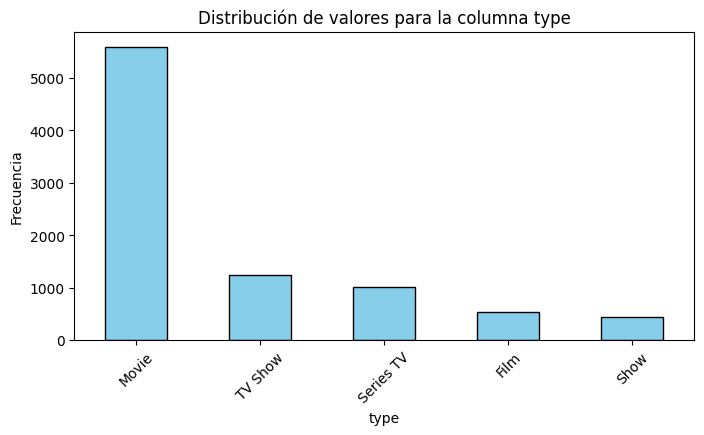

Valores únicos en la columna 'type': ['Movie' 'TV Show' 'Film' 'Show' 'Series TV']
No se requiere transformación inmediata para la columna 'type'.


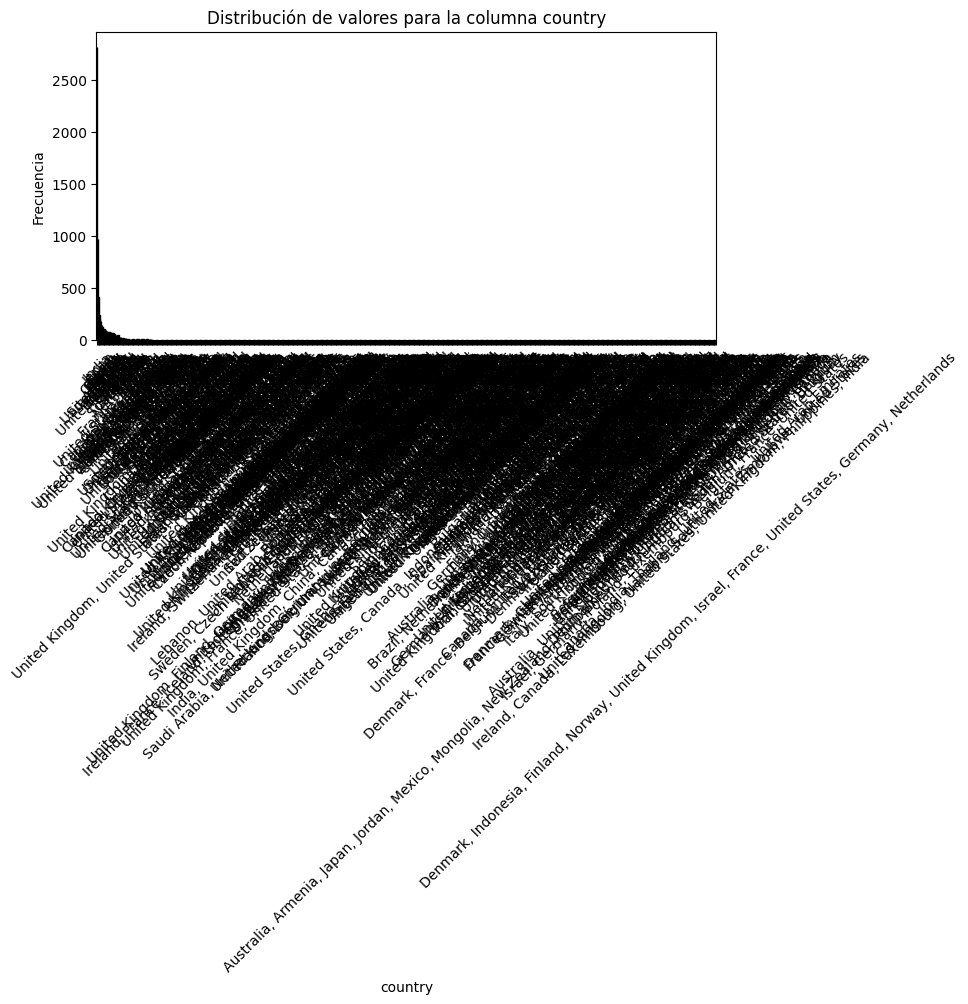

Valores únicos en la columna 'country': ['United States' 'South Africa' 'India'
 'United States, Ghana, Burkina Faso, United Kingdom, Germany, Ethiopia'
 'United Kingdom' 'Germany, Czech Republic' 'Mexico' 'Turkey' 'Australia'
 'United States, India, France' 'Finland' 'China, Canada, United States'
 'South Africa, United States, Japan' 'Nigeria' 'Japan'
 'Spain, United States' 'France' 'Belgium' 'United Kingdom, United States'
 'United States, United Kingdom' 'France, United States' 'South Korea'
 'Spain' 'United States, Singapore' 'United Kingdom, Australia, France'
 'United Kingdom, Australia, France, United States'
 'United States, Canada' 'Germany, United States'
 'South Africa, United States' 'United States, Mexico'
 'United States, Italy, France, Japan'
 'United States, Italy, Romania, United Kingdom'
 'Australia, United States' 'Argentina, Venezuela'
 'United States, United Kingdom, Canada' 'China, Hong Kong' 'Russia'
 'Canada' 'Hong Kong' 'United States, China, Hong Kong'
 'Ita

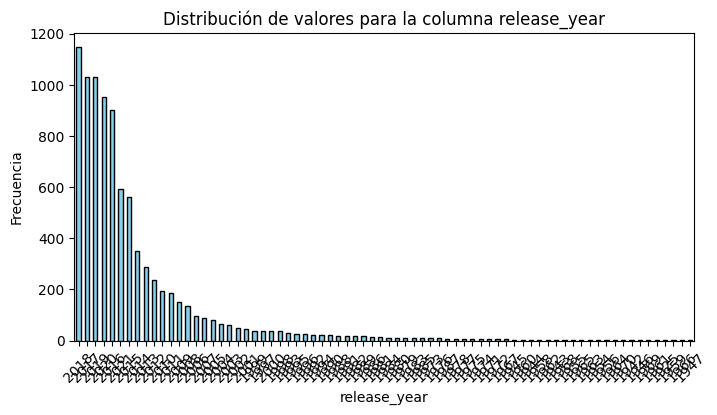

Valores únicos en la columna 'release_year': [2020 2021 1993 2018 1996 1998 1997 2010 2013 2017 1975 1978 1983 1987
 2012 2001 2014 2002 2003 2004 2011 2008 2009 2007 2005 2006 1994 2015
 2019 2016 1982 1989 1990 1991 1999 1986 1992 1984 1980 1961 2000 1995
 1985 1976 1959 1988 1981 1972 1964 1945 1954 1979 1958 1956 1963 1970
 1973 1925 1974 1960 1966 1971 1962 1969 1977 1967 1968 1965 1946 1942
 1955 1944 1947 1943]
No se requiere transformación inmediata para la columna 'release_year'.


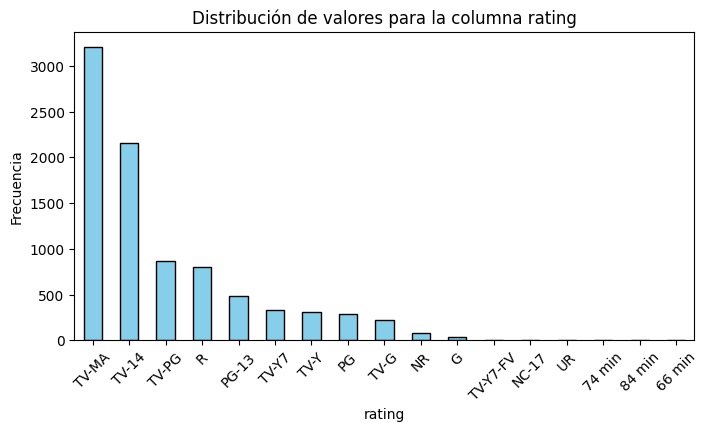

Valores únicos en la columna 'rating': ['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' '74 min' '84 min' '66 min' 'NR' 'TV-Y7-FV' 'UR']
Se sugiere verificar los valores en la columna 'rating' por posibles inconsistencias, como valores incorrectos o nulos.


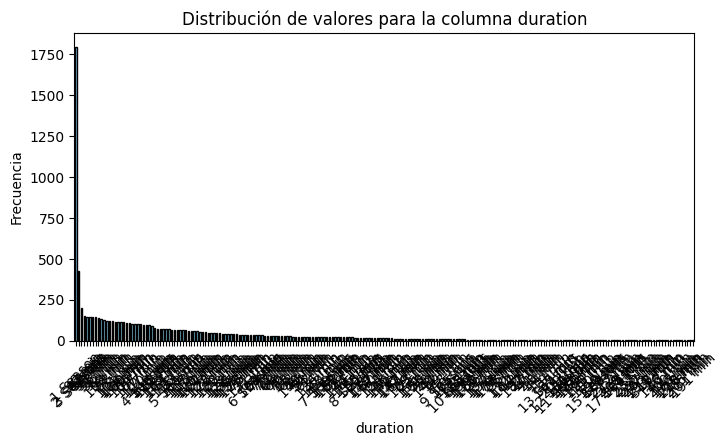

Valores únicos en la columna 'duration': ['90 min' '2 Seasons' '1 Season' '91 min' '125 min' '9 Seasons' '104 min'
 '127 min' '4 Seasons' '67 min' '94 min' '5 Seasons' '161 min' '61 min'
 '166 min' '147 min' '103 min' '97 min' '106 min' '111 min' '3 Seasons'
 '110 min' '105 min' '96 min' '124 min' '116 min' '98 min' '23 min'
 '115 min' '122 min' '99 min' '88 min' '100 min' '6 Seasons' '102 min'
 '93 min' '95 min' '85 min' '83 min' '113 min' '13 min' '182 min' '48 min'
 '145 min' '87 min' '92 min' '80 min' '117 min' '128 min' '119 min'
 '143 min' '114 min' '118 min' '108 min' '63 min' '121 min' '142 min'
 '154 min' '120 min' '82 min' '109 min' '101 min' '86 min' '229 min'
 '76 min' '89 min' '156 min' '112 min' '107 min' '129 min' '135 min'
 '136 min' '165 min' '150 min' '133 min' '70 min' '84 min' '140 min'
 '78 min' '7 Seasons' '64 min' '59 min' '139 min' '69 min' '148 min'
 '189 min' '141 min' '130 min' '138 min' '81 min' '132 min' '10 Seasons'
 '123 min' '65 min' '68 min' '66 min' '6

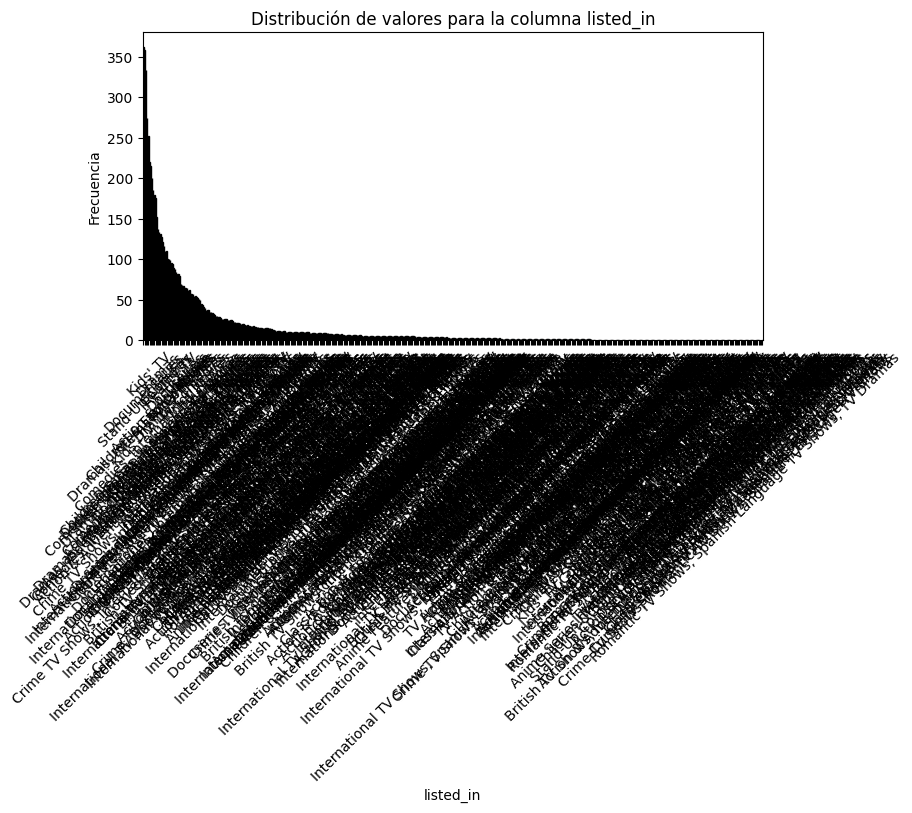

Valores únicos en la columna 'listed_in': ['Documentaries' 'International TV Shows, TV Dramas, TV Mysteries'
 'Crime TV Shows, International TV Shows, TV Action & Adventure'
 'Docuseries, Reality TV'
 'International TV Shows, Romantic TV Shows, TV Comedies'
 'TV Dramas, TV Horror, TV Mysteries' 'Children & Family Movies'
 'Dramas, Independent Movies, International Movies'
 'British TV Shows, Reality TV' 'Comedies, Dramas'
 'Crime TV Shows, Docuseries, International TV Shows'
 'Dramas, International Movies' 'Children & Family Movies, Comedies'
 'British TV Shows, Crime TV Shows, Docuseries' 'TV Comedies, TV Dramas'
 'Documentaries, International Movies'
 'Crime TV Shows, Spanish-Language TV Shows, TV Dramas' 'Thrillers'
 'International TV Shows, Spanish-Language TV Shows, TV Action & Adventure'
 'International TV Shows, TV Action & Adventure, TV Dramas'
 'Comedies, International Movies'
 'Comedies, International Movies, Romantic Movies'
 'Docuseries, International TV Shows, Reality TV'


In [10]:
import matplotlib.pyplot as plt

# Recorrer las columnas con baja cardinalidad
for columna in columnas_baja_cardinalidad:
    # Mostrar la distribución de los valores
    plt.figure(figsize=(8, 4))
    df_peliculas[columna].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribución de valores para la columna {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()
    
    # Mostrar los valores únicos
    valores_unicos = df_peliculas[columna].dropna().unique()
    print(f"Valores únicos en la columna '{columna}': {valores_unicos}")
    
    # Evaluación para acciones de limpieza o transformación
    if columna == 'rating':  # Un ejemplo de columna donde podrían haber valores inconsistentes
        print(f"Se sugiere verificar los valores en la columna '{columna}' por posibles inconsistencias, como valores incorrectos o nulos.")
    elif columna == 'country':  # Supongamos que en 'country' pueden haber valores inconsistentes como "USA" y "Estados Unidos"
        print(f"Es posible que los valores en la columna '{columna}' deban estandarizarse (por ejemplo, 'USA' a 'United States').")
    else:
        print(f"No se requiere transformación inmediata para la columna '{columna}'.")


4. Limpia o simplifica/transforma dos de los campos detectados en 3, si hay al menos dos, si no, uno. Para ello puedes:  
4.1 Cualquier agrupa los valores de los campos tipo categoría con categorías similares que se llamen distinto.  
4.2 Quita valores extraños o que no correspondan. Conviertelos a "", y luego busca un valor para sustituirlos.

In [11]:
# 1. Limpiar la columna 'country' (agrupar categorías similares y eliminar valores extraños)
df_peliculas['country'] = df_peliculas['country'].replace({
    'USA': 'United States',
    'United States of America': 'United States',
    'UK': 'United Kingdom',
    'Estados Unidos': 'United States',
    'Francia': 'France',
    'España': 'Spain'
})

# Eliminar valores extraños o vacíos (como 'Not Available', 'Unknown', etc.)
df_peliculas['country'] = df_peliculas['country'].replace({
    '': 'Unknown',
    'Unknown': 'Unknown',
    'Not Available': 'Unknown'
})

# Ver los resultados de la columna 'country'
print("Columna 'country' limpia:")
print(df_peliculas['country'].value_counts())


Columna 'country' limpia:
country
United States                                    2818
India                                             972
United Kingdom                                    419
Japan                                             245
South Korea                                       199
                                                 ... 
Russia, Spain                                       1
Croatia, Slovenia, Serbia, Montenegro               1
Japan, Canada                                       1
United States, France, South Korea, Indonesia       1
United Arab Emirates, Jordan                        1
Name: count, Length: 748, dtype: int64


In [12]:
# 2. Limpiar la columna 'rating' (por ejemplo, valores no válidos o desconocidos)
df_peliculas['rating'] = df_peliculas['rating'].replace({
    'not rated': 'NR',  # Transformar 'not rated' a 'NR' (Not Rated)
    'unknown': 'NR',    # Transformar 'unknown' a 'NR'
    '': 'NR',           # Transformar valores vacíos a 'NR'
    'NaN': 'NR'         # Transformar 'NaN' a 'NR' (si aparece)
})

# Ver los resultados de la columna 'rating'
print("Columna 'rating' limpia:")
print(df_peliculas['rating'].value_counts())


Columna 'rating' limpia:
rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64


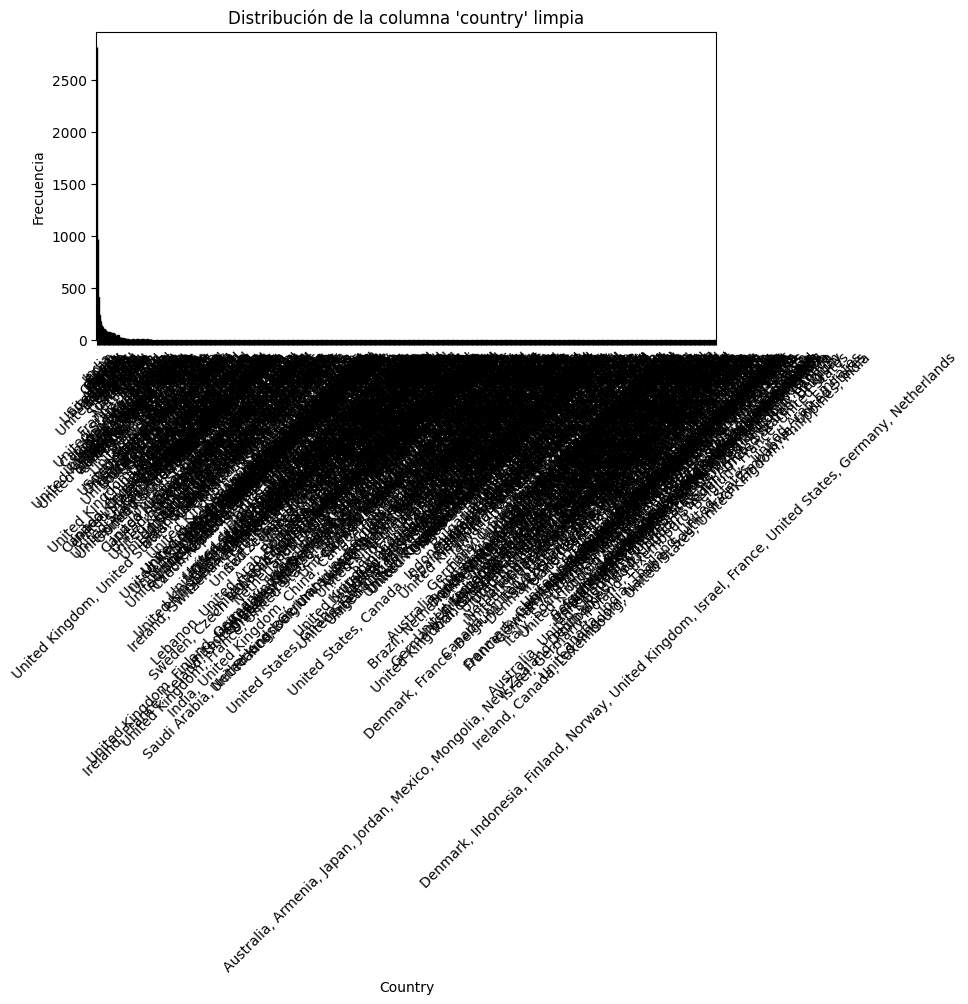

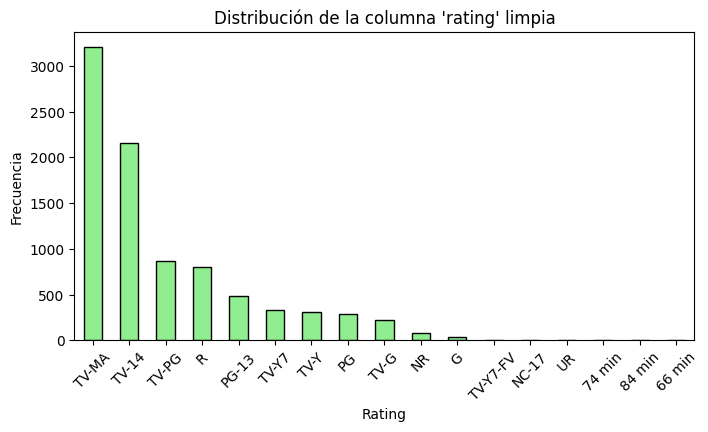

In [13]:
# 3. Mostrar las columnas después de la limpieza
# Distribución de los valores en 'country'
plt.figure(figsize=(8, 4))
df_peliculas['country'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución de la columna 'country' limpia")
plt.xlabel('Country')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Distribución de los valores en 'rating'
plt.figure(figsize=(8, 4))
df_peliculas['rating'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribución de la columna 'rating' limpia")
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


5. Convierte o cambia el tipo de la columna con fechas en strings a un tipo datetime. La columna que son solo años es mejor dejarla como integer, porque se opera muy fácil así. Tendrás que analizar los argumentos de pd.datetime y jugar con ellos para poder conseguirlo.

In [16]:
# Verificar los nombres de las columnas del DataFrame
print(df_peliculas.columns)


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [17]:
import pandas as pd

# Reemplaza 'release_date' y 'year' por los nombres correctos de tus columnas
df_peliculas['release_date'] = pd.to_datetime(df_peliculas['release_date'], errors='coerce', dayfirst=False)
df_peliculas['year'] = pd.to_numeric(df_peliculas['year'], errors='coerce', downcast='integer')

# Verificar las conversiones
print("Primeras filas después de la conversión:")
print(df_peliculas[['release_date', 'year']].head())



KeyError: 'release_date'

## #3 Tratamiento de Missings/Nulos

Es hora de tratar los nulos. Así que habrá que identificarlos para empezar.

1. Haz una lista con las columnas que contienen valores nulos. Obtenla a "mano" mirando la salid del método info o bien haz un programa que las obtenga de forma automática.

In [18]:
# Método info() te dará un resumen general del DataFrame, incluidas las columnas con valores nulos
df_peliculas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [19]:
# Obtener las columnas con valores nulos automáticamente
columnas_nulas = df_peliculas.columns[df_peliculas.isnull().any()].tolist()

# Mostrar las columnas con valores nulos
print("Columnas con valores nulos:")
print(columnas_nulas)


Columnas con valores nulos:
['director', 'cast', 'country', 'date_added', 'rating', 'duration']


2. Obten el porcentaje de valores nulos para cada una de las columnas.

In [20]:
# Obtener el porcentaje de valores nulos por columna
porcentaje_nulos = df_peliculas.isnull().mean() * 100

# Mostrar el porcentaje de valores nulos por columna
print("Porcentaje de valores nulos por columna:")
print(porcentaje_nulos)


Porcentaje de valores nulos por columna:
show_id          0.000000
type             0.000000
title            0.000000
director        29.908028
cast             9.367549
country          9.435676
date_added       0.113546
release_year     0.000000
rating           0.045418
duration         0.034064
listed_in        0.000000
description      0.000000
dtype: float64


3. Corrige de la mejor manera que se te ocurra las dos columnas con menor porcentajes de nulos.

In [21]:
# Obtener el porcentaje de valores nulos por columna
porcentaje_nulos = df_peliculas.isnull().mean() * 100

# Ordenar las columnas por porcentaje de valores nulos en orden ascendente
columnas_menor_nulos = porcentaje_nulos.sort_values().head(2)

# Mostrar las dos columnas con menor porcentaje de nulos
print("Columnas con menor porcentaje de nulos:")
print(columnas_menor_nulos)


Columnas con menor porcentaje de nulos:
show_id    0.0
type       0.0
dtype: float64


In [23]:
# Imputar las dos columnas con menor porcentaje de nulos
for col in columnas_menor_nulos.index:
    if df_peliculas[col].dtype == 'object':  # Si es una columna categórica
        # Rellenar los nulos con la moda de la columna
        moda = df_peliculas[col].mode()[0]
        df_peliculas[col].fillna(moda, inplace=True)
    else:  # Si es una columna numérica
        # Rellenar los nulos con la media de la columna
        media = df_peliculas[col].mean()
        df_peliculas[col] = df_peliculas[col].fillna(moda)


# Verificar el resultado
print("Datos después de la imputación:")
print(df_peliculas[columnas_menor_nulos.index].isnull().sum())


Datos después de la imputación:
show_id    0
type       0
dtype: int64


C:\Users\johan\AppData\Local\Temp\ipykernel_14636\564495347.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_peliculas[col].fillna(moda, inplace=True)


4. En un caso como este, que no hay apenas valores numéricos y las columnas con nulos no son categóricas, es mejor o deshacerse de los nulos o bien simplemente marcarlos pero convertidos a un valor más manejable y del tipo del resto de valores de la columna en la que aparecen. Por eso cambia los nulos en las columnas que no hayas tratado en el apartado anterior por "UNK" o por "".

In [24]:
# Identificar las columnas que no son numéricas ni categóricas
columnas_restantes = df_peliculas.select_dtypes(exclude=['number', 'object']).columns

# Reemplazar los valores nulos por 'UNK' o '' en esas columnas
for col in columnas_restantes:
    # Reemplazar los valores nulos por "UNK" o "" dependiendo del tipo de la columna
    df_peliculas[col].fillna("UNK", inplace=True)

# Verificar los cambios
print("Datos después de reemplazar nulos en columnas restantes:")
print(df_peliculas[columnas_restantes].isnull().sum())


Datos después de reemplazar nulos en columnas restantes:
Series([], dtype: float64)


5. Comprueba ahora que no hemos generado duplicados, si existiesen borralos y quedate la primera ocurrencia.

In [25]:
# Verificar si existen duplicados
print("Número de filas antes de eliminar duplicados:", df_peliculas.shape[0])

# Eliminar duplicados, manteniendo la primera ocurrencia
df_peliculas.drop_duplicates(keep='first', inplace=True)

# Verificar después de eliminar duplicados
print("Número de filas después de eliminar duplicados:", df_peliculas.shape[0])

# Verificar si siguen existiendo duplicados
print("¿Existen duplicados?", df_peliculas.duplicated().sum())


Número de filas antes de eliminar duplicados: 8807
Número de filas después de eliminar duplicados: 8807
¿Existen duplicados? 0


## #4 Generación de nuevos datos

Para terminar de hacer nuestro procesado, intentemos enriquecer el dataset y obtener alguna información adicional.

1. Separa el dataset en dos dataframes,uno de películas y otro de series. A veces aunque los datos parecen de la misma naturaleza, puede ser bueno separarlos para trabajar con ellos de forma independiente.

In [26]:
# Comprobar las primeras filas para verificar si existe una columna 'type'
print(df_peliculas.head())

# Si la columna 'type' existe y tiene valores como 'Movie' y 'TV Show', separarlas
df_peliculas_movies = df_peliculas[df_peliculas['type'] == 'Movie']
df_peliculas_shows = df_peliculas[df_peliculas['type'] == 'TV Show']

# Mostrar la cantidad de películas y series
print(f"Número de películas: {df_peliculas_movies.shape[0]}")
print(f"Número de series: {df_peliculas_shows.shape[0]}")

# Verificar las primeras filas de ambos DataFrames
print("Primeras filas del DataFrame de películas:")
print(df_peliculas_movies.head())

print("Primeras filas del DataFrame de series:")
print(df_peliculas_shows.head())


  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

2. Ahora además podemos sacarle más provecho a algunos campos, por ejemplo duration. Muestra la distribución de valores para cada dataframe del campo "duration".

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\johan\AppData\Local\Temp\ipykernel_14636\1445655118.py:8: SyntaxWarning: invalid escape sequence '\d'
  df_peliculas_movies['duration'] = df_peliculas_movies['duration'].str.extract('(\d+)').astype(float)  # Extraer minutos
C:\Users\johan\AppData\Local\Temp\ipykernel_14636\1445655118.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peliculas_movies['duration'] = df_peliculas_movies['duration'].str.extract('(\d+)').astype(float)  # Extraer minutos
C:\Users\johan\AppData\Local\Temp\ipykernel_14636\1445655118.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

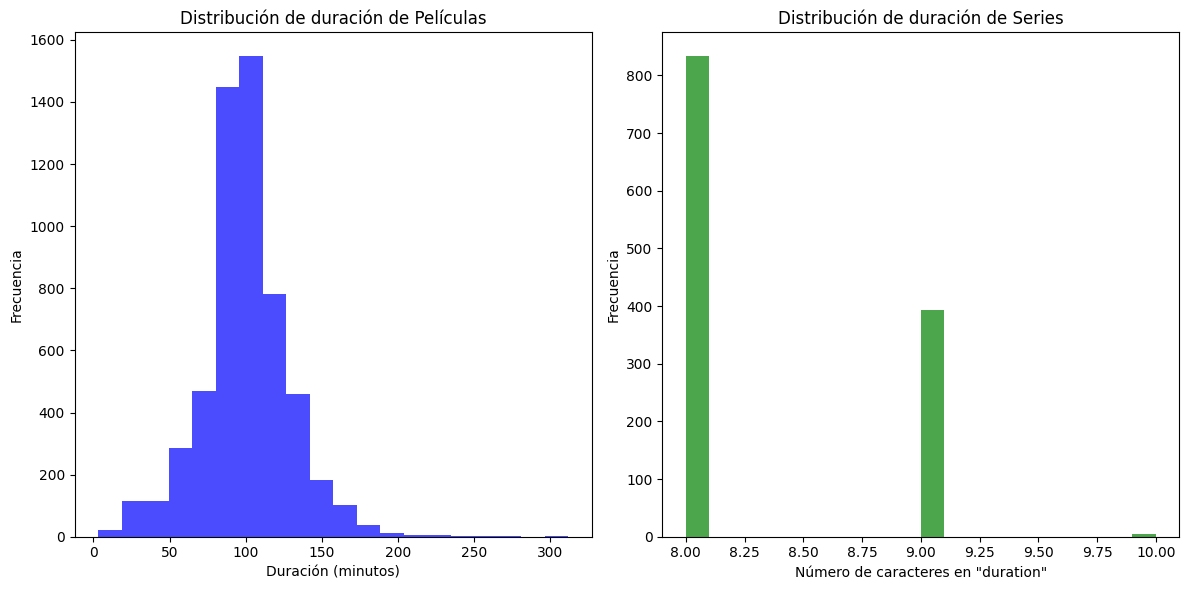

In [27]:
import matplotlib.pyplot as plt

# Comprobar la distribución de valores de la columna 'duration' en el DataFrame de películas
plt.figure(figsize=(12, 6))

# Distribución de 'duration' para películas
plt.subplot(1, 2, 1)
df_peliculas_movies['duration'] = df_peliculas_movies['duration'].str.extract('(\d+)').astype(float)  # Extraer minutos
plt.hist(df_peliculas_movies['duration'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribución de duración de Películas')
plt.xlabel('Duración (minutos)')
plt.ylabel('Frecuencia')

# Distribución de 'duration' para series
plt.subplot(1, 2, 2)
# Las series no deberían tener una duración fija, por lo que tal vez 'duration' esté vacío o nulo
# Si hay valores nulos, los eliminamos antes de la visualización
df_peliculas_shows['duration'] = df_peliculas_shows['duration'].fillna('UNK')  # Reemplazamos nulos por 'UNK' si es necesario
plt.hist(df_peliculas_shows[df_peliculas_shows['duration'] != 'UNK']['duration'].apply(len), bins=20, color='green', alpha=0.7)
plt.title('Distribución de duración de Series')
plt.xlabel('Número de caracteres en "duration"')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


3. Convierte los valores de "duration" en cada dataframe a valores numéricos y cambia en el de las series el nombre por uno más representativo. Se valorará el emplear una expresión regular para obtener la información.

In [28]:
import pandas as pd
import re

# Paso 1: Convertir la duración de las películas a valores numéricos
# Para las películas, extraemos los minutos (solo números)
df_peliculas_movies['duration'] = df_peliculas_movies['duration'].str.extract(r'(\d+)').astype(float)

# Paso 2: Convertir la duración de las series a valores numéricos (duración por episodio)
# Si la columna 'duration' de las series contiene valores de duración de episodios, extraemos los minutos
df_peliculas_shows['episode_duration'] = df_peliculas_shows['duration'].str.extract(r'(\d+)').astype(float)

# Cambiar el nombre de la columna 'duration' a 'episode_duration' para las series
df_peliculas_shows.rename(columns={'duration': 'episode_duration'}, inplace=True)

# Verificación
print("Primeras filas de películas después de la conversión de 'duration':")
print(df_peliculas_movies[['duration']].head())

print("\nPrimeras filas de series después de la conversión de 'duration' a 'episode_duration':")
print(df_peliculas_shows[['episode_duration']].head())



AttributeError: Can only use .str accessor with string values!

4. BONUS: Crea un campo "Posible_Secuela" en el dataset de películas con valor a False por defecto. Intenta (con expresiones regulares si es posible) hacer una función que aplicada (con apply) a un título determine si es una posible secuela o no. Emplea la función (con apply) para rellenar el campo "Posible_Secuela". Nota: No hace falta que sea infalible,ni que las cace todas sino que tenga una lógica defendible, piensa en la forma que normalmente tienen las secuelas, por ejemplo la de Terminator.m..